# Supervision des réseaux
## Détection d'intrusion : Méthode Lakhina Entropy
<div>
Groupe 9 :
<ul><li>AMATU Jonathan</li><li>BERCY Victor</li><li>SEMPERE Nicolas</li>
</div>
<div></div>
<div>Dataset CTU-13 : <a href=https://www.stratosphereips.org/datasets-ctu13>lien</a></div>
<div></div>
<div>[1] Papier original : An empirical comparison of botnet detection methods, S. García et al.</div>
<div>[2] Papier Lakhina Entropy : Mining anomalies using traffic feature distributions, A. Lakhina et al.</div>

### 0 - Imports

In [5]:
# Bibliothèques scientifiques
import math
import pandas as pd
import numpy as np
from numpy import linalg as LA

# Bibliothèque de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

# Bibliothèque graphique
import matplotlib.pyplot as plt

# Boîte à outils
from datetime import datetime
import warnings

#### 1 - Pré-traitement du jeu de données

On charge les données d'un scénario dans un dataframe pour l'analyse statistique.

In [6]:
num_scenario = 42
kept_fields = ["StartTime","Dur","Proto","SrcAddr","Sport","DstAddr","Dport","TotPkts","TotBytes","Label"]

scenario = pd.read_csv(f'./Datasets/CTU13_{num_scenario}.binetflow', usecols=kept_fields)
scenario

,StartTime,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,TotPkts,TotBytes,Label
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,147.32.84.229,13363,12,875,flow=Background-UDP-Established
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,147.32.84.229,13363,2,135,flow=Background-UDP-Established
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,147.32.86.194,2063,2,120,flow=Background
3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,147.32.85.5,21857,3,180,flow=Background
4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,147.32.84.229,13363,42,2856,flow=Background-UDP-Established
...,...,...,...,...,...,...,...,...,...,...
2824631,2011/08/10 15:54:07.352393,0.000393,udp,147.32.86.92,36363,147.32.80.9,53,2,208,flow=To-Background-UDP-CVUT-DNS-Server
2824632,2011/08/10 15:54:07.353854,0.000935,udp,58.165.41.84,60122,147.32.84.229,13363,2,539,flow=Background-UDP-Established
2824633,2011/08/10 15:54:07.357302,0.000000,tcp,147.32.84.171,47077,78.191.168.43,13754,1,74,flow=Background-TCP-Attempt
2824634,2011/08/10 15:54:07.366830,0.002618,udp,93.79.39.15,10520,147.32.84.229,13363,2,520,flow=Background-UDP-Established


Les labels ayant des noms longs et complexes pour le traitement que l'on souhaite leur appliquer, on les rassemble en 3 classes comme présenté dans le papier : Background, Normal, Botnet. On associe ensuite les labels 0 et 1 respectivement aux classes Background/Normal et Botnet pour la détection à suivre.

In [7]:
def get_class(full_name):
    """
    Get the class of the netflow (Normal, Background, Botnet) from the full name of the label given by CTU-13 dataset
    """
    if "Background" in full_name:
        return "Background"
    elif "Botnet" in full_name:
        return "Botnet"
    elif "Normal" in full_name:
        return "Normal"
    else:
        return "None"
    
def get_label(full_name):
    """
    Assign a label to the netflow (0 for Normal and Background, 1 for Botnet, -1 for unknown label) from the full name of the label given by CTU-13 dataset
    """
    if "Background" in full_name or "Normal" in full_name:
        return 0
    elif "Botnet" in full_name:
        return 1
    else:
        return -1

De plus, la colonne StartTime contient les instants à partir desquels l'échange de données (le netflow) a débuté. On a choisi de la convertir en une colonne de timestamps, plus faciles à manipuler.

In [8]:
def to_timestamp(date_string):
    """
    Transform the date of the dataframe into a timestamp
    """
    month_split = date_string.split('/')
    day_split = month_split[-1].split(' ')
    hour_split = day_split[-1].split(':')
    second_split = hour_split[-1].split('.')

    year = int(month_split[0])
    month = int(month_split[1])
    day = int(day_split[0])
    hour = int(hour_split[0])
    minute = int(hour_split[1])
    second = int(second_split[0])
    microsecond = int(second_split[1])
    date = datetime(year, month, day, hour, minute, second, microsecond)

    return date.timestamp()

On applique les fonctions précédentes à l'ensemble des données de notre jeu.

In [9]:
scenario = scenario.assign(
    Class=scenario['Label'].apply(get_class),
    Label=scenario['Label'].apply(get_label),
    StartTime=scenario['StartTime'].apply(to_timestamp)
)
scenario.head(10)

,StartTime,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,TotPkts,TotBytes,Label,Class
0,1.312962e+09,3550.182373,udp,212.50.71.179,39678,147.32.84.229,13363,12,875,0,Background
1,1.312962e+09,0.000883,udp,84.13.246.132,28431,147.32.84.229,13363,2,135,0,Background
2,1.312962e+09,0.000326,tcp,217.163.21.35,80,147.32.86.194,2063,2,120,0,Background
3,1.312962e+09,0.056966,tcp,83.3.77.74,32882,147.32.85.5,21857,3,180,0,Background
4,1.312962e+09,3427.768066,udp,74.89.223.204,21278,147.32.84.229,13363,42,2856,0,Background
5,1.312962e+09,3086.547363,tcp,66.169.184.207,49372,147.32.84.229,13363,591,45931,0,Background
6,1.312962e+09,3589.631348,udp,182.239.167.121,49649,147.32.84.229,13363,12,1494,0,Background
7,1.312962e+09,20.360268,tcp,147.32.3.93,443,147.32.84.59,51790,133,81929,0,Background
8,1.312962e+09,3118.470947,udp,24.117.206.20,8697,147.32.84.229,13363,13,4328,0,Background
9,1.312962e+09,1065.003052,tcp,94.208.78.74,50687,147.32.84.229,13363,156,14804,0,Background


In [9]:
normal_data = scenario[scenario['Label']==0]
botnet_data = scenario[scenario['Label']==1]

### 2 - Analyse d'un scénario de la base de données CTU-13

Débutons par une analyse du jeu de données en notre possession.

On commence par observer la répartition des différentes classes (Normal, Background, Botnet) dans le scénario.

In [10]:
nb_rows = len(scenario)

labels_count = pd.Series(
    scenario['Class'].value_counts(),
    name='Count'
)

labels_percentage = pd.Series(
    labels_count
    .apply(lambda x: f"{np.round(x/nb_rows*100, 3)} %"),
    index=labels_count.index,
    name='Percentage'
)

pd.concat([labels_count, labels_percentage], axis=1)

,Count,Percentage
Class,,
Background,2753288,97.474 %
Botnet,40961,1.45 %
Normal,30387,1.076 %


On retrouve la répartition présentée dans le papier fourni [1], en observant que très peu des flux réseau sont réellement dus à un botnet.

#### Analyse des adresses IP et ports

On regarde le nombre d'adresses IP et ports sources et destinations uniques au sein de chacune des différentes classes de flux réseau.

In [11]:
scenario.groupby("Class", group_keys=True)[["SrcAddr", "Sport", "DstAddr", "Dport"]].nunique()


,SrcAddr,Sport,DstAddr,Dport
Class,,,,
Background,542087,64737,115092,73781
Botnet,1,3975,4190,27
Normal,19,18631,545,93


On remarque encore une fois une différence majeure entre les classes Background/Normal et Botnet. Intéressons nous plus en détails à l'/aux adresse(s) IP associée(s) à la classe Botnet.

In [12]:
print("L'adresse IP de l'hôte infectée est : {}".format(
    scenario[scenario['Label']==1]['SrcAddr'].unique()
))

L'adresse IP de l'hôte infectée est : ['147.32.84.165']


Pour la plupart des scénarios, on remarque qu'il n'y a qu'un seul hôte infecté qui émet sur différents ports et vers différents adresses IP et ports. Pour les autres scénarios, à savoir le n°44 (2 adresses IP), le n°50 (10 adresses IP), le n°51 (10 adresses IP), le n°52 (3 adresses IP) et le n°53 (9 adresses IP), on remarque que les botnets appartiennent à un même sous-réseau de masque 142.32.84.0/24.

En comparaison, essayons d'analyser la répartition des adresses IP des classes Background et Normal.

In [13]:
warnings.filterwarnings("ignore")

unique_src_addr = scenario[scenario['Label']==0]['SrcAddr'].unique()

print("Les adresses IP de destination du jeu de données sont au nombre de {}, en voici un extrait : {}.\n".format(
    len(unique_src_addr),
    unique_src_addr
))

print("Parmi elles, {} % sont de la forme 147.32.84.X et {} % font partie du sous réseau de masque 80.0.0.0/4.".format(
    np.round(pd.Series(unique_src_addr)
     .str.contains('147.32.84.', regex=False)
     .value_counts()
     .loc[True]
     /len(unique_src_addr)*100,
     2
     ),
    np.round(pd.Series(unique_src_addr)
     .str.contains('^(8[0-9]|9[0-5]).*', regex=True)
     .value_counts()
     .loc[True]
     /len(unique_src_addr)*100,
     2
    )
))


Les adresses IP de destination du jeu de données sont au nombre de 542092, en voici un extrait : ['212.50.71.179' '84.13.246.132' '217.163.21.35' ... '83.46.238.157'
 '98.87.173.219' '88.222.4.220'].

Parmi elles, 0.02 % sont de la forme 147.32.84.X et 33.1 % font partie du sous réseau de masque 80.0.0.0/4.


In [14]:
unique_dst_addr = scenario['DstAddr'].unique()

print("Les adresses IP de destination du jeu de données sont au nombre de {}, en voici un extrait : {}.\n".format(
    len(unique_dst_addr),
    unique_dst_addr
))

print("Parmi elles, {} % sont de la forme 147.32.84.X et {} % font partie du sous réseau de masque 80.0.0.0/4.".format(
    np.round(pd.Series(unique_dst_addr)
     .str.contains('147.32.84.', regex=False)
     .value_counts()
     .loc[True]
     /len(unique_dst_addr)*100,
     2
     ),
    np.round(pd.Series(unique_dst_addr)
     .str.contains('^(8[0-9]|9[0-5]).*', regex=True)
     .value_counts()
     .loc[True]
     /len(unique_dst_addr)*100,
     2
    )
))

warnings.filterwarnings("default")

Les adresses IP de destination du jeu de données sont au nombre de 119296, en voici un extrait : ['147.32.84.229' '147.32.86.194' '147.32.85.5' ... '93.80.227.24'
 '87.244.129.22' '86.147.113.119'].

Parmi elles, 0.21 % sont de la forme 147.32.84.X et 27.15 % font partie du sous réseau de masque 80.0.0.0/4.


On ne peut pas dire grand chose sur les adresses IP sources non issues de botnet et de destination des flux. Cependant, on peut émettre l'hypothèse que, pour tous les scénarios, entre 20% et 25% de ces deux types d'adresses font partie d'un sous-réseau commun de masque 80.0.0.0/4.

#### Analyse de la durée des flux réseau

La méthode Lakhina Entropy découpant le flux supervisé en fenêtres temporelles de taille fixe, on s'intéresse à la durée des flux réseau de notre jeu de données.

In [15]:
stats = scenario[['StartTime', 'Dur']].describe()

print("Le scénario a été enregistré sur une durée totale de {} minutes.".format(
    np.round((stats['StartTime'].loc['max'] - stats['StartTime'].loc['min'])/60, 2)
))
print("Un flux réseau du scénario dure en moyenne {} minutes. La durée minimale observée est de {} minutes, celle maximale est de {} minutes.".format(
    np.round((stats['Dur'].loc['mean'])/60, 1),
    np.round((stats['Dur'].loc['min'])/60, 1),
    np.round((stats['Dur'].loc['max'])/60, 1)
))
stats

Le scénario a été enregistré sur une durée totale de 367.24 minutes.
Un flux réseau du scénario dure en moyenne 7.2 minutes. La durée minimale observée est de 0.0 minutes, celle maximale est de 60.0 minutes.


,StartTime,Dur
count,2.824636e+06,2.824636e+06
mean,1.312973e+09,4.322060e+02
std,6.525920e+03,9.958423e+02
min,1.312962e+09,0.000000e+00
25%,1.312967e+09,3.130000e-04
50%,1.312973e+09,1.194000e-03
75%,1.312979e+09,9.012607e+00
max,1.312984e+09,3.600031e+03


On remarque qu'en moyenne les flux réseau durent en moyenne 7 minutes 12 secondes et jusqu'à 1 heure, soit plus que la taille de la fenêtre temporelle proposée dans le papier Lakhnina Entropy [2] (5 minutes). Il faudra trouver une solution pour intégrer ces flux réseau au traitement.

Observons plus en détails la répartition des durées des flux réseau.

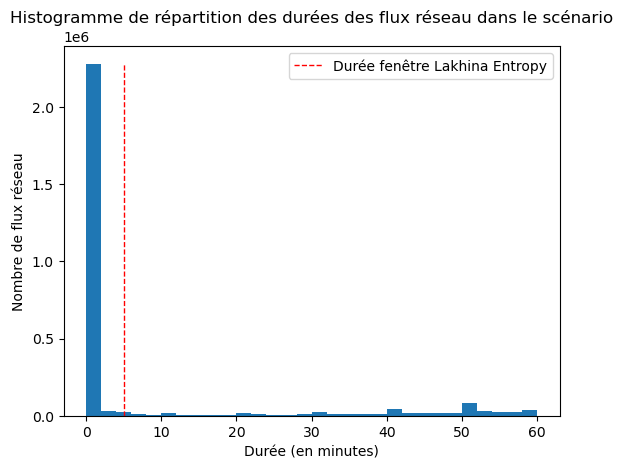

In [17]:
duration = scenario['Dur'].apply(lambda x: x/60)

counts, _, _ = plt.hist(duration, bins=30)
plt.plot([5, 5], [0, max(counts)], 'r--', linewidth=1, label='Durée fenêtre Lakhina Entropy')

plt.xlabel("Durée (en minutes)")
plt.ylabel("Nombre de flux réseau")
plt.title("Histogramme de répartition des durées des flux réseau dans le scénario")
plt.legend(loc=0)

plt.show()

La majorité des flux sont d'une durée inférieure à la taille de la fenêtre proposée dans le papier Lakhina Entropy [2]. Cependant, on observe que des flux réseau sont étalés sur une durée bien plus grande que la fenêtre d'échantillonage. Il faudra traiter ces cas particuliers dans le traitement suivant.

### 3 - Lakhina Entropy